# Preprocessing Data

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt

## Memuat Dataset

In [15]:
data = pd.read_csv('dataset/enhanced_student_habits_performance_dataset.csv')

## Pembersihan Data
### Menghapus kolom student_id (tidak relevan untuk prediksi)

In [16]:
data = data.drop(columns=['student_id'], errors='ignore')

### Identifikasi Kolom Numerik, Kategorikal, dan Boolean
Identifikasi kolom numerik dan kategorikal

In [17]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

# Identifikasi kolom boolean berdasarkan nilai unik (misalnya, 'Yes'/'No', 'True'/'False')
boolean_cols = []
for col in categorical_cols:
    unique_vals = data[col].dropna().unique()
    if set(unique_vals).issubset({'Yes', 'No'}) or set(unique_vals).issubset({'True', 'False'}) or len(unique_vals) == 2:
        boolean_cols.append(col)
        categorical_cols.remove(col)

print("\n=== Kolom Numerik ===")
print(numerical_cols)
print("\n=== Kolom Kategorikal ===")
print(categorical_cols)
print("\n=== Kolom Boolean ===")
print(boolean_cols)


=== Kolom Numerik ===
['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'attendance_percentage', 'sleep_hours', 'exercise_frequency', 'mental_health_rating', 'previous_gpa', 'semester', 'stress_level', 'social_activity', 'screen_time', 'parental_support_level', 'motivation_level', 'exam_anxiety_score', 'time_management_score', 'exam_score']

=== Kolom Kategorikal ===
['gender', 'major', 'diet_quality', 'parental_education_level', 'internet_quality', 'dropout_risk', 'study_environment', 'family_income_range', 'learning_style']

=== Kolom Boolean ===
['part_time_job', 'extracurricular_participation', 'access_to_tutoring']


### Menangani Nilai Hilang
Imputasi nilai hilang: mean untuk numerik, modus untuk kategorikal dan boolean

In [18]:
for col in numerical_cols:
    data[col].fillna(data[col].mean(), inplace=True)

for col in categorical_cols + boolean_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)

# Verifikasi tidak ada nilai hilang
print("\n=== Jumlah Nilai Hilang Setelah Imputasi ===")
print(data.isnull().sum())


=== Jumlah Nilai Hilang Setelah Imputasi ===
age                              0
gender                           0
major                            0
study_hours_per_day              0
social_media_hours               0
netflix_hours                    0
part_time_job                    0
attendance_percentage            0
sleep_hours                      0
diet_quality                     0
exercise_frequency               0
parental_education_level         0
internet_quality                 0
mental_health_rating             0
extracurricular_participation    0
previous_gpa                     0
semester                         0
stress_level                     0
dropout_risk                     0
social_activity                  0
screen_time                      0
study_environment                0
access_to_tutoring               0
family_income_range              0
parental_support_level           0
motivation_level                 0
exam_anxiety_score               0
learning_

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17780\1358755582.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17780\1358755582.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

### Menangani Outlier (menggunakan metode IQR)

In [19]:
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Clip outlier ke batas IQR
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

Visualisasi boxplot setelah penanganan outlier

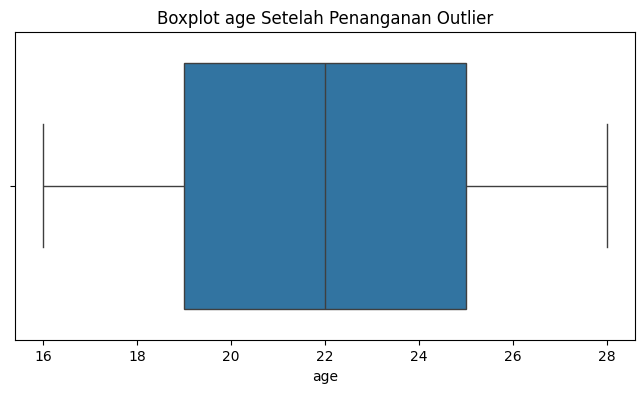

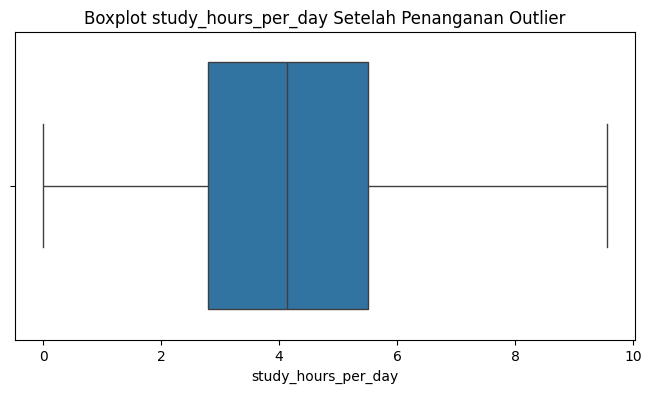

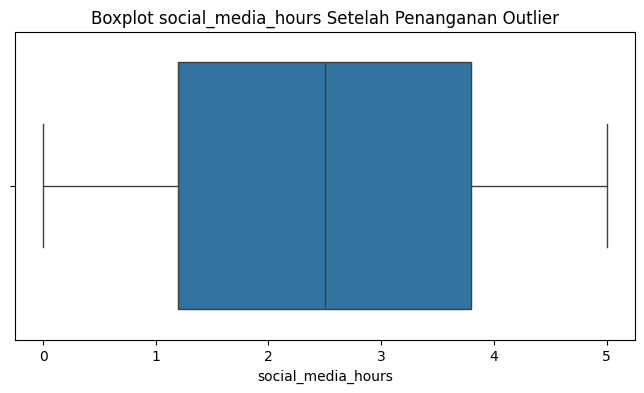

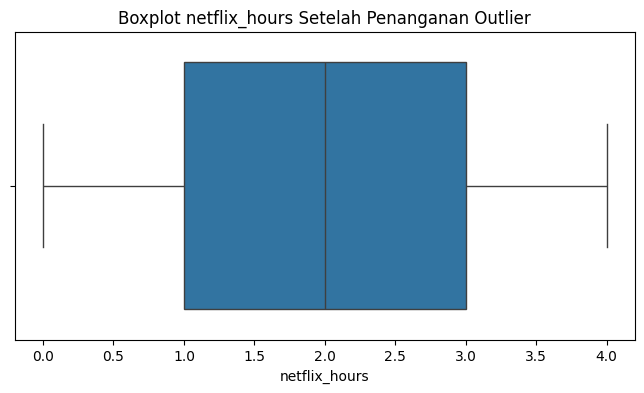

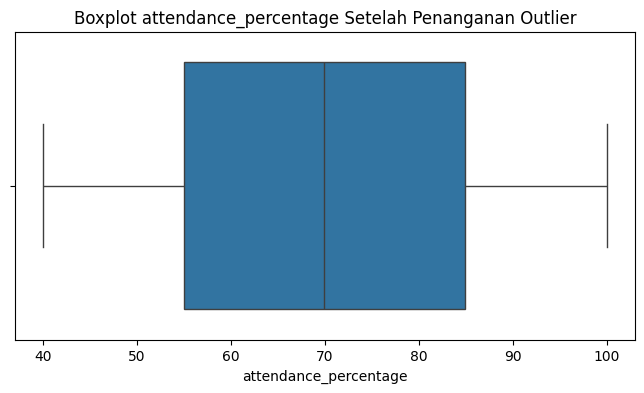

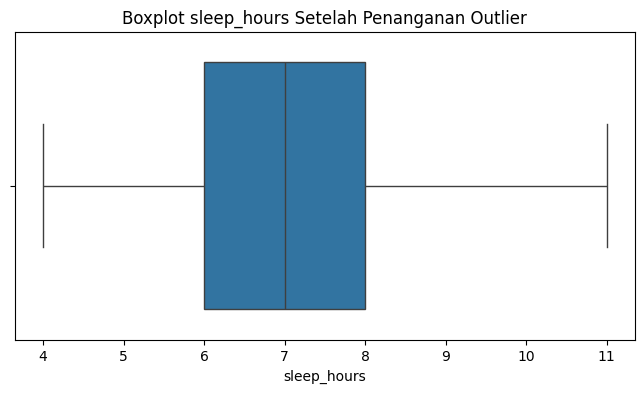

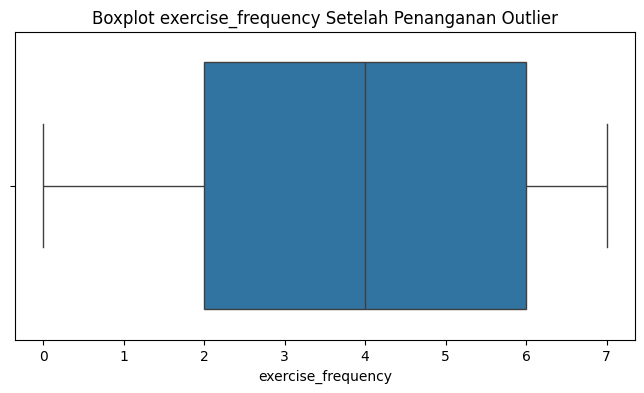

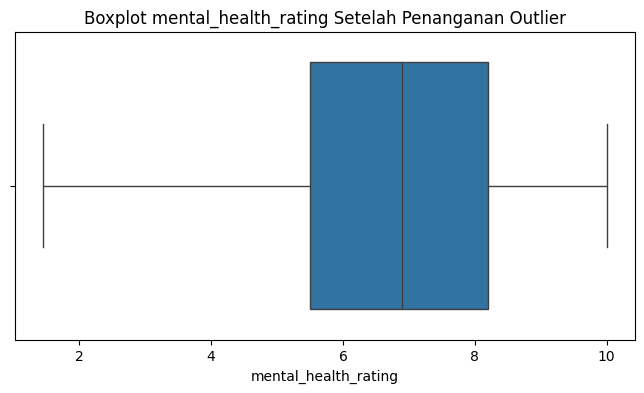

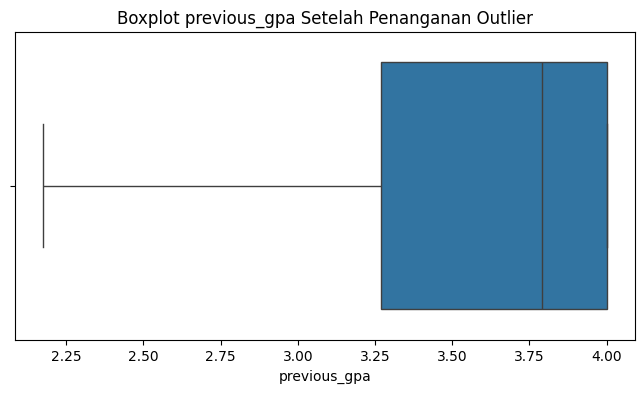

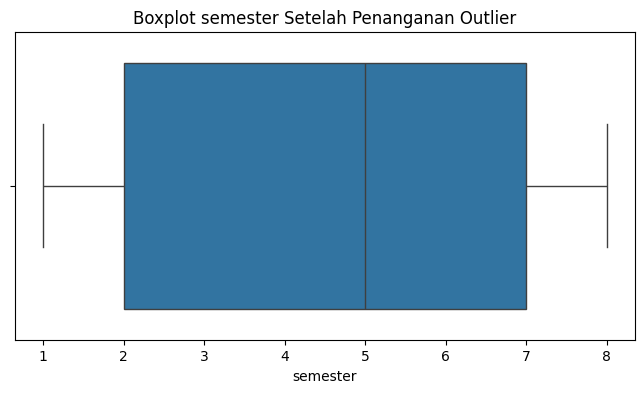

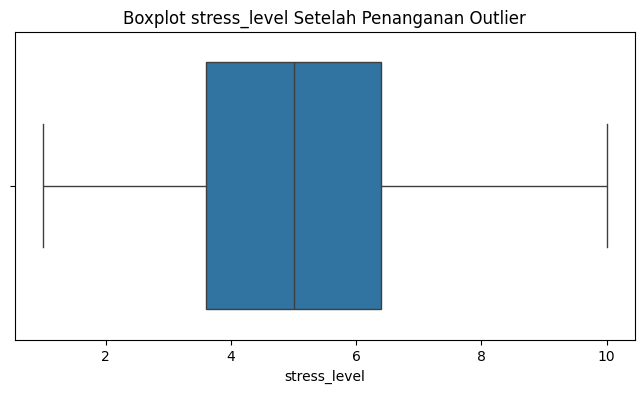

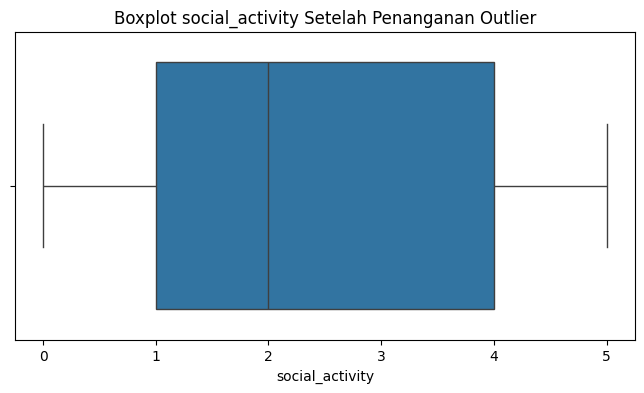

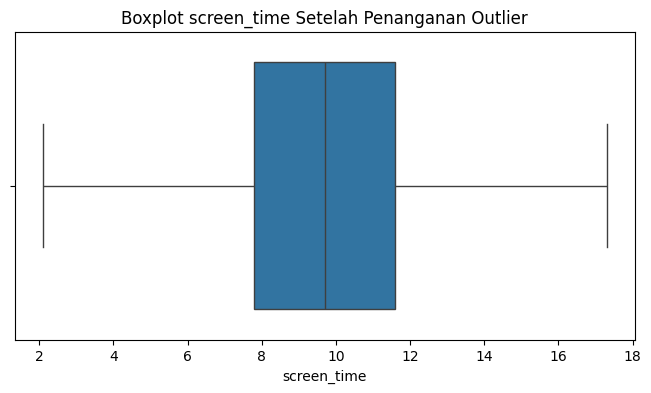

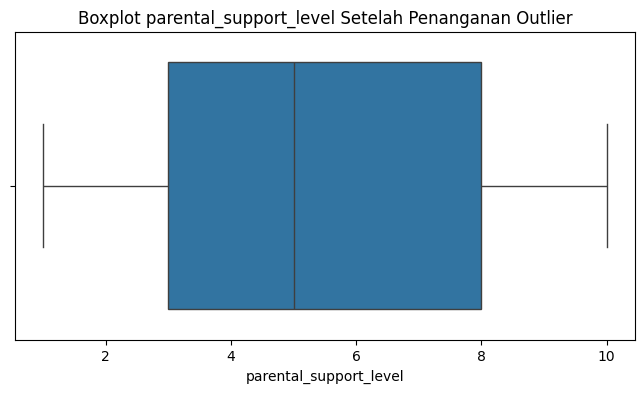

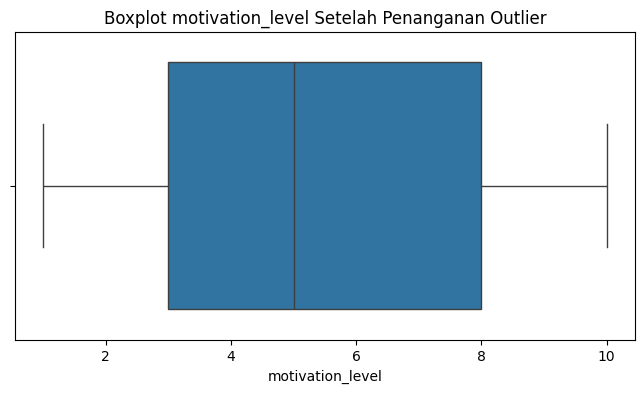

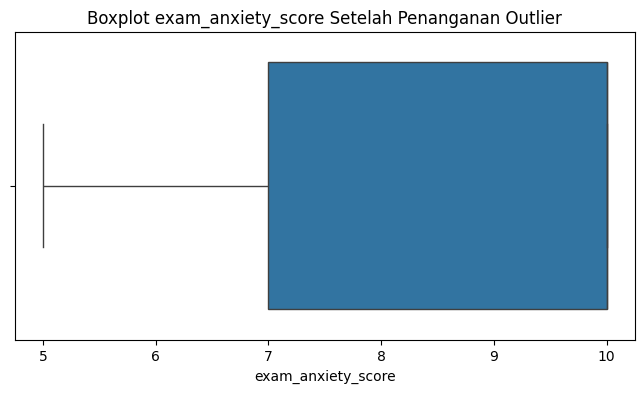

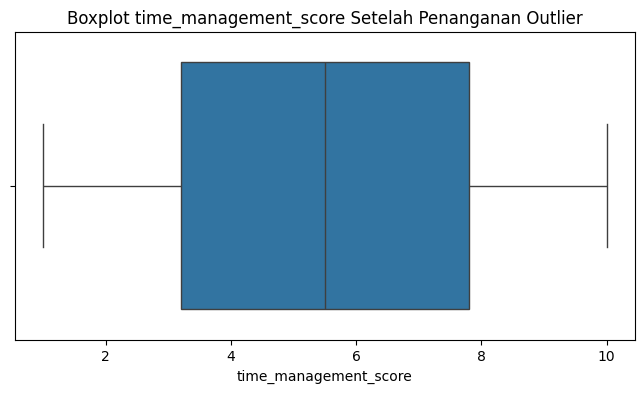

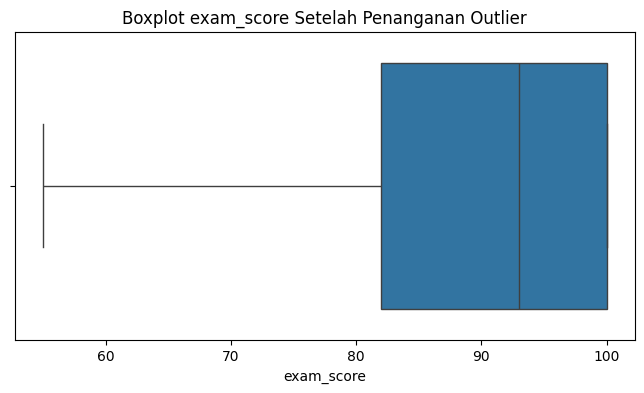

In [20]:
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot {col} Setelah Penanganan Outlier')
    plt.show()

## Preprocessing
### Boolean Encoding
Encode kolom boolean menjadi 0/1

In [21]:

for col in boolean_cols:
    data[col] = data[col].map({'Yes': 1, 'No': 0, 'True': 1, 'False': 0}).astype(int)
    if data[col].isin([0, 1]).all():
        continue
    else:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])

print("\n=== Kolom Boolean Setelah Encoding ===")
for col in boolean_cols:
    print(f"{col}: {data[col].unique()}")


=== Kolom Boolean Setelah Encoding ===
part_time_job: [1 0]
extracurricular_participation: [1 0]
access_to_tutoring: [1 0]


### Encoding Variabel Kategorikal
One-Hot Encoding untuk variabel nominal

In [22]:
nominal_cols = ['gender', 'major', 'study_environment', 'learning_style']
# Pastikan nominal_cols hanya berisi kolom yang ada di dataset dan bukan boolean
nominal_cols = [col for col in nominal_cols if col in categorical_cols]
if nominal_cols:
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_nominal = encoder.fit_transform(data[nominal_cols])
    encoded_nominal_df = pd.DataFrame(
        encoded_nominal,
        columns=encoder.get_feature_names_out(nominal_cols)
    )
    data = data.drop(columns=nominal_cols)
    data = pd.concat([data, encoded_nominal_df], axis=1)

# Label Encoding untuk variabel ordinal
ordinal_cols = ['diet_quality', 'exercise_frequency', 'parental_education_level',
                'internet_quality', 'mental_health_rating', 'stress_level',
                'dropout_risk', 'social_activity', 'family_income_range',
                'parental_support_level', 'motivation_level']
ordinal_cols = [col for col in ordinal_cols if col in data.columns]
for col in ordinal_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

#### Label Encoding untuk variabel ordinal

In [10]:
ordinal_cols = ['diet_quality', 'exercise_frequency', 'parental_education_level',
                'internet_quality', 'mental_health_rating', 'extracurricular_participation',
                'stress_level', 'dropout_risk', 'social_activity', 'family_income_range',
                'parental_support_level', 'motivation_level']
for col in ordinal_cols:
    if col in data.columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])

### Normalisasi Fitur Numerik (Standarisasi)

In [23]:
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

### Seleksi Fitur (Metode Tambahan)
Menggunakan korelasi untuk memilih fitur numerik

In [24]:
correlation_matrix = data[numerical_cols].corr()
exam_score_corr = correlation_matrix['exam_score'].abs().sort_values(ascending=False)
selected_features_corr = exam_score_corr[exam_score_corr > 0.2].index.tolist()
print("\n=== Fitur Numerik dengan Korelasi Tinggi (|corr| > 0.2) ===")
print(selected_features_corr)


=== Fitur Numerik dengan Korelasi Tinggi (|corr| > 0.2) ===
['exam_score', 'previous_gpa', 'motivation_level', 'study_hours_per_day', 'exam_anxiety_score']


Menggunakan feature importance dari Random Forest

In [25]:
X = data.drop(columns=['exam_score'])
y = data['exam_score']
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
selected_features_rf = feature_importance[feature_importance > 0.01].index.tolist()
print("\n=== Fitur dengan Importance Tinggi dari Random Forest (> 0.01) ===")
print(selected_features_rf)


=== Fitur dengan Importance Tinggi dari Random Forest (> 0.01) ===
['previous_gpa', 'attendance_percentage']


Visualisasi feature importance

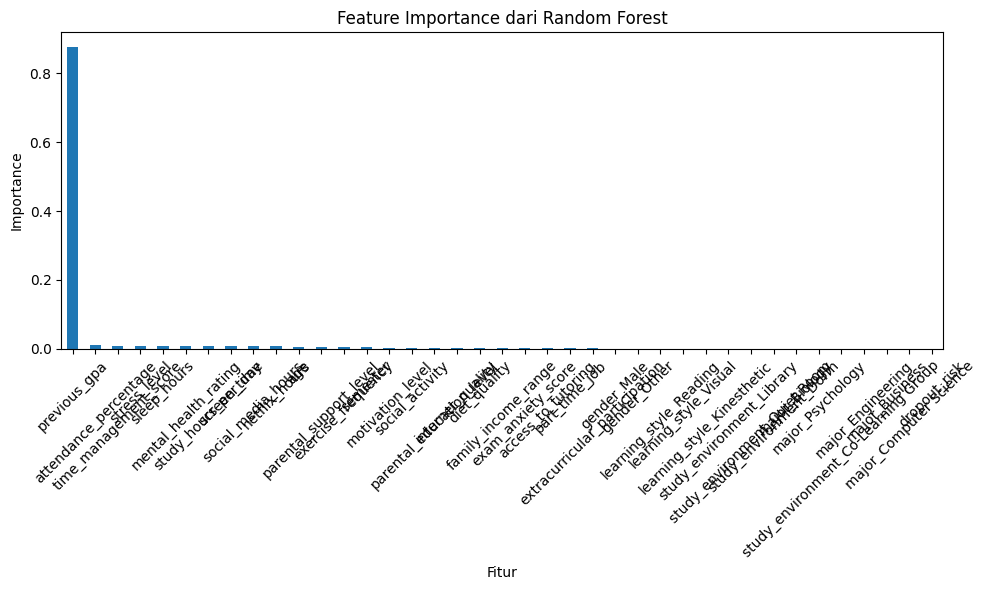

In [26]:
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance dari Random Forest')
plt.xlabel('Fitur')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Menggabungkan fitur terpilih (korelasi + RF)

In [27]:
selected_features = list(set(selected_features_corr + selected_features_rf))
print("\n=== Fitur Terpilih untuk Pemodelan ===")
print(selected_features)


=== Fitur Terpilih untuk Pemodelan ===
['exam_anxiety_score', 'previous_gpa', 'exam_score', 'attendance_percentage', 'motivation_level', 'study_hours_per_day']


In [29]:
# Menyimpan dataset yang telah diproses
data.to_csv('dataset/processed_student_data.csv', index=False)